In [2]:
# size dist plus growth rates
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline
from scipy.stats import norm
from scipy.stats import pareto

import pandas as pd

from scipy.special import erf


### Empirical number of agents and total value
Recommendation: 

1e5 agents. 

~1e11.5 EUR annually 

In [3]:
# The size dists are:
#  - Lognormal clipped x > 3. 
sigma = 1.2810683494198207 # 1.3149476902828778
mu = 4.536908110675739 # 4.470439741406725
# 11.5% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

# We'll try different N's, until we can match the avg level of France imports 

tot_val = []
Ns = np.array(np.round(np.power(10, np.arange(4.5, 5.5, .01))), dtype = int)

for N in Ns:
    N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
    draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
    draw = np.sort(draw)[-N:]
    tot_val += [np.power(10, draw).sum()] # (=y)

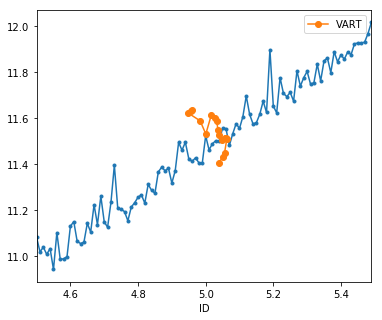

In [4]:
data_path = './../../data/processed/'

df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]
empirical = df.groupby(['YEAR']).agg({'ID': 'count', 'VART': 'sum'}) # count == nunique


fig, ax = plt.subplots(1, figsize = (6, 5))

ax.plot(np.log10(Ns), np.log10(tot_val), marker = '.')
np.log10(empirical).plot('ID', 'VART', marker = 'o', ax = ax)
plt.show()
# *think that mu, sigma are for pooled data, but they could be different in each year.

## Size distributions

In [5]:
N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
draw = np.sort(draw)[-N:]

# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns


In [6]:
# From the theoretical N and the ppf we can know the theoretical quantiles
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()

n = N_tail
x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# PARETO
z_0 = -1.1042021 #-1.1771
# value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
value_qs_1 = 6.67465

norm = 1.375
x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1, q = q) for q in np.arange(0, 1, 1/(norm*N_tail)) + .5/(norm*N_tail)])
np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
x1 = x1[int(-norm*N_tail - 1):-1]
x_pareto = np.log10(x1)

8260 11.374044168927085
100000 11.438183817742505
6008 11.392426993120676


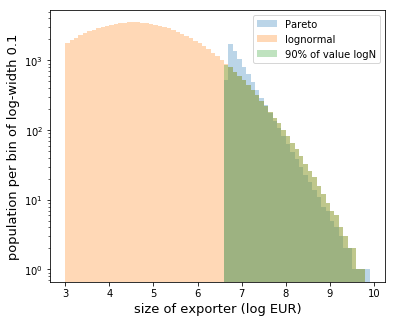

In [7]:


#previous
# x_pareto = np.log10(np.random.pareto(-z_0, 2*n) + 1 ) + value_qs_1
# x_pareto = np.sort(x_pareto)

# Plot Histogram. Distribution debug
bw = .1
bins_ = np.arange(3, 10, bw)

fig, ax = plt.subplots(1, figsize = (6, 5))
ax.hist(x_pareto, bins_, alpha = .3, label = 'Pareto')
ax.hist(x_logn_clip3, bins_, alpha = .3, label = 'lognormal')
ax.hist(x_logn_clip3_90, bins_, alpha = .3, label = '90% of value logN')

ax.set_ylabel('population per bin of log-width '+str(bw), fontsize = 13)
ax.set_xlabel('size of exporter (log EUR)', fontsize = 13)
ax.legend()
plt.yscale('log')

# Check population and value in all three size dists. 
for x in [x_pareto, x_logn_clip3, x_logn_clip3_90]:
    print(len(x), np.log10(np.power(10, x).sum()))
    
plt.savefig('./../../../thesis_writing/figures/size_dists_demo.png')
plt.show()

In [8]:
# pareto.pdf(x, b, loc, scale)
# pareto.pdf((x - loc) / scale, b) / scale

In [9]:
# Need to reconciliate... For the moment I use quick and dirty... just sort the random generated..


# pareto_array = np.log10(np.random.pareto(-z_0, N_tail) + 1 ) + value_qs_1
# # pareto_array = np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
# x1 = np.sort(pareto_array)

## n_q plots

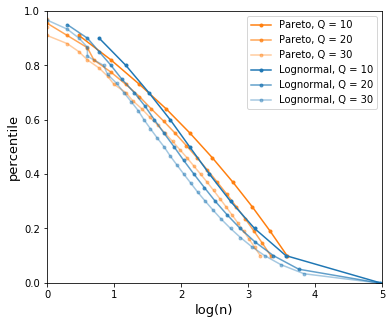

In [10]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for i, Q in enumerate([10, 20, 30]):
    ns = get_n(x_pareto, Q)[1]
    ax.plot(np.log10(ns), .1 + 0.9*(np.arange(Q)/Q), marker = '.', c = '#ff7f0e', alpha = [1, .7, .4][i], label = 'Pareto, Q = '+str(Q))
    
for i, Q in enumerate([10, 20, 30]):
    ns = get_n(x_logn_clip3, Q)[1]
    ax.plot(np.log10(ns), np.arange(Q)/Q, marker = '.', c = '#1f77b4', alpha = [1, .7, .4][i], label = 'Lognormal, Q = '+str(Q))

ax.set_ylabel('percentile', fontsize = 13)
ax.set_xlabel('log(n)', fontsize = 13)
ax.set_ylim(0, 1)
ax.set_xlim(0, 5)
ax.legend()
plt.savefig('./../../../thesis_writing/figures/quantile_logn.png', dpi = 400)

plt.show()

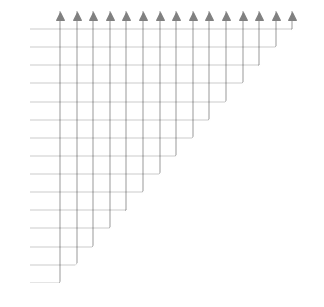

In [87]:
#eg levels = (np.arange(Q)/Q)[::2]

def plot_levels_reflex(levels, ax):
    for level in levels:
        ax.axhline(level, lw = .4, c = 'k', alpha = .5)
        ax.axvline(level, lw = .4, c = 'k')
        ax.fill_between([0, 1], [0, 1], color = 'w', zorder = 10)
        ax.set_xlim(-0.12, 1)
        ax.set_ylim(0, 1)
        plt.axis('off')
    # ax.plot(levels, levels, '+', markersize = 15, c = '.5')
    ax.plot(levels, len(levels)*[.98], '^', markersize = 8, c = '.5')

In [23]:
import seaborn as sns
pal = sns.color_palette('tab10')
pal.as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Empirical GR

In [14]:
gr_info = pd.read_csv('./../../data/processed/g_rates_info.csv')

In [20]:
T = 16
x0 = pd.Series(draw)
g_rates_list = []

# size dependent growth rates
for s in np.arange(3, 11.5, .5):
    x0_s = x0.loc[abs(x0 - s) < .25]
    gr_s = gr_info.loc[abs(gr_info.level - s) < .5]  
    
    if len(gr_s) > 0:
        g_rates_long = gr_s.sample(len(x0_s) * int(T/2), replace = True)
        g_rates = g_rates_long[['logdiff1', 'logdiff2']].values.reshape(len(x0_s), T)
        g_rates_list += [g_rates]
    
g_rates = pd.DataFrame(np.vstack(g_rates_list))

# If T is made many x T we could have repetitions with little effort...

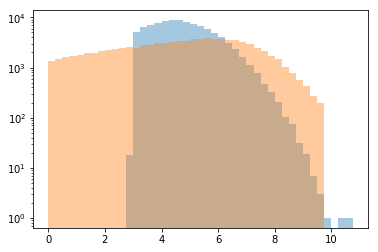

In [21]:
plt.hist(x0.values, np.arange(0, 11, .25), alpha = .4)
plt.hist(x0.values + g_rates.cumsum(axis = 1)[15], np.arange(0, 10, .25), alpha = .4)
plt.yscale('log')
plt.show()

In [121]:
len(x_logn_clip3)

100000

In [237]:
# T = 16
x0 = pd.Series(x_logn_clip3)
g_rates_list = []

# size dependent growth rates
for s in np.arange(3, 11.5, .5):
    x0_s = x0.loc[abs(x0 - s) < .25]
    gr_s = df_growth.loc[abs(df_growth.iloc[:, -1] - s) < .6]
    
    if len(gr_s) > 0:
        g_rates = gr_s.sample(len(x0_s), replace = True)
        g_rates_list += [g_rates]
g_rates = pd.DataFrame(np.vstack(g_rates_list))
# LET Growth Rates CUMSUM TO 0
g_rates.iloc[:, 0:16] = (g_rates.iloc[:, 0:16].values.T - g_rates.iloc[:, 0:16].mean(1).values).T

In [113]:
df_growth = pd.read_csv('./../../data/processed/g_rates_16_info.csv', index_col=0, header = [0, 1])
np.log10(np.power(10, df_growth.iloc[:, -1]).sum())

def empirical_gr_time_series(x0 = x_logn_clip3, T = 16, clip = np.inf):
    """
    x0: np.array()
        Initial sizes (in logs)
    
    returns:
        g_rates. np.array of shape (N, T)
        
    """
    x0 = pd.Series(x0)
    g_rates_list = []

    # size dependent growth rates
    for s in np.arange(3, 11.5, .5):
        x0_s = x0.loc[abs(x0 - s) < .25] # A chunk of the initial values
        gr_s = df_growth.loc[abs(df_growth.iloc[:, -1] - s) < .6] # A chunk of firm growth rates time series around the same size.

        if len(gr_s) > 0: # For non empty chunks
            g_rates = gr_s.sample(len(x0_s), replace = True) # sample its growth rates
            g_rates_list += [g_rates]
    g_rates = pd.DataFrame(np.vstack(g_rates_list))

    g_rates = np.clip(g_rates, -clip, clip)
    return g_rates.iloc[:, 0:T].values

In [156]:
# # how many of them are clipped?
# x1 = x_logn_clip3_90
# g_rates = empirical_gr_time_series(x1, T)
# 100*(abs(g_rates) > .8).sum()/(g_rates.shape[0] * g_rates.shape[1])

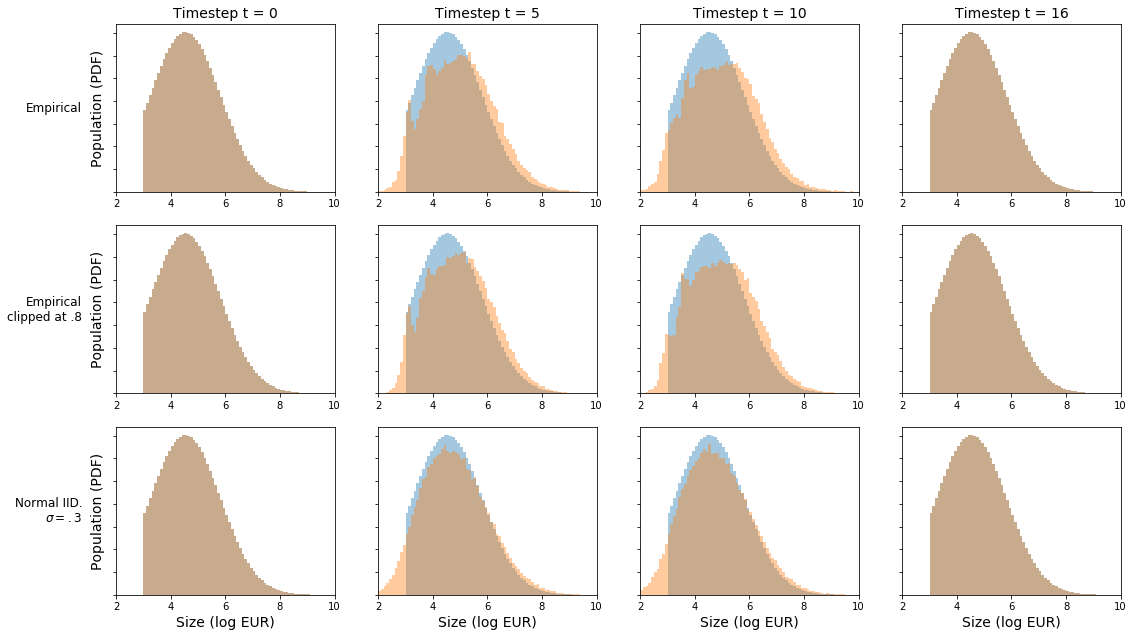

In [143]:
tsteps = [0, 5, 10, 16]
growth_rates = ['emp_szd_T16', 'emp_szd_T16_clip.8', 'norm']#, 'lapl', 'sbtn']
fig, axs = plt.subplots(len(growth_rates), len(tsteps), figsize = (len(tsteps)*4.5, len(growth_rates)*3.5))

x1 = x_logn_clip3

s = .3

for k, dist in enumerate(growth_rates):
    if dist == 'emp_szd_T16_clip.8':
        g_rates = empirical_gr_time_series(x1, T, clip = .8)
    elif dist == 'emp_szd_T16':
        g_rates = empirical_gr_time_series(x1, T)
    elif dist == 'norm':
        g_rates = np.random.normal(0, s, (N, T))
    elif dist == 'lapl':
        g_rates = np.random.laplace(0, s, (N, T))/np.sqrt(2)
    else:
        g_rates = gennorm.rvs(1/2, size = (N, T))* (s / 10.925)

    g_rates = (g_rates.T - g_rates.mean(axis = 1)).T
    g_rates = np.hstack([np.zeros((len(x1), 1)), g_rates])

    for j, t in enumerate(tsteps):
        ax = axs[k][j]
        ax.hist(x1, np.arange(0, 11, .1), alpha = .4)
        ax.hist(x1 + g_rates.cumsum(axis = 1)[:, t], np.arange(0, 11, .1), alpha = .4)
        ax.set_xlim(2, 10)
        ax.set_yticklabels('')
        
        if k == 0:
            ax.set_title('Timestep t = '+str(t), fontsize = 14)
        if j == 0:
            ax.set_ylabel('Population (PDF)', fontsize = 14)
        if k == len(growth_rates) - 1:
            ax.set_xlabel('Size (log EUR)', fontsize = 14)


# cols = ['Column {}'.format(col) for col in range(1, 4)]
# rows = ['Row {}'.format(row) for row in ['A', 'B', 'C', 'D']]
pad = 5
names = ['Empirical', 'Empirical\nclipped at .8', 'Normal IID.\n'+r'$\sigma = .3$']
for ax, row_name in zip(axs[:,0], names):
    ax.annotate(row_name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

plt.savefig('./../../../thesis_writing/figures/dispersion_demo.png')
plt.show()


In [22]:
# There is some issue, distribution gets deformed over time.

## Modeled GR
- Non correlated
    - Gaussian (a = 2)
    - Laplace (a = 1)
    - Subbotin (a = 1/2)

### Empirical (does not depend on s)

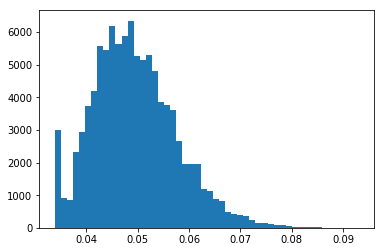

In [26]:
standard_deviations = np.array([.02,.05, .1, .2, .3, .4, .5])

plt.hist(np.std(empirical_gr_time_series(x1, T + 1)*(2*standard_deviations[0]), 1), 50)
plt.show()

In [59]:
for j, x1 in enumerate([x_pareto, x_logn_clip3_90, x_logn_clip3]):
    g_rates = np.clip(empirical_gr_time_series(x1, T), -.8, .8)
#     g_rates = empirical_gr_time_series(x1, T)
    np.hstack([np.zeros((len(x1), 1)), empirical_gr_time_series(x1, T)])
    g_rates = g_rates*(2*s) #What I get here is a 'turning on' of the empirical growth rates.
    print(g_rates.std()/s)

0.3747471606166559
0.3729122209482985
0.6792664703102539


In [53]:
g_rates = np.random.laplace(0, s, (N, T + 1))/np.sqrt(2)
g_rates.var()

0.0024926276161088426

In [86]:

from scipy.stats import gennorm

# x0 = pd.Series(draw)
# x1 is the exact distribution

I = 200
T = 16

standard_deviations = np.array([.02,.05, .1, .2, .3, .4, .5])
n_Quantiles = np.array([10, 15, 20, 25])

# El objetivo de esto es sacar cuanto va valiendo std y var.
# Dale.. ya las conozco. Tengo que poder ir subiendo de a cero para algunos quantiles.

# Ahi atender que sigma y sigma sq van a tener dependencia propia. Me va a ayudar usar las dos. 
# Aunque estan simplemente relacionadas porque una es la otra al cuadrado.

for j, x1 in enumerate([x_pareto, x_logn_clip3_90, x_logn_clip3]):
# for j, x1 in enumerate([x_logn_clip3]):
    N = len(x1)
    sizes = ['pareto', 'logn90', 'logn'][j]
#     sizes = ['logn'][j]
    print(sizes)
    for k, dist in enumerate(['emp_szd_T16_clip.8']):#, 'emp_szd_T16', 'norm', 'lapl', 'sbtn']):
        print(dist)
        res_l = []
        for s in standard_deviations:
        # for s in [.1]:
            print(s)
            for Q in n_Quantiles:
        #     for Q in [10]:
                print(Q)
                bins, ns = get_n(x1, Q)
                res_sQi_l = []
                for i in range(I):
#                     if i%10 == 0: print(i)
                    if dist == 'emp_szd_T16_clip.8':
                        g_rates = empirical_gr_time_series(x1, T, clip = .8)
                        g_rates = g_rates*(2*s) #What I get here is a 'turning on' of the empirical growth rates.
                    if dist == 'emp_szd_T16':
                        g_rates = empirical_gr_time_series(x1, T)
                        g_rates = g_rates*(2*s) #What I get here is a 'turning on' of the empirical growth rates.
                    elif dist == 'norm':
                        g_rates = np.random.normal(0, s, (N, T))
                    elif dist == 'lapl':
                        g_rates = np.random.laplace(0, s, (N, T))/np.sqrt(2)
                    else:
                        g_rates = gennorm.rvs(1/2, size = (N, T))* (s / 10.925)
                        
                    # # If T is made many x T we could have repetitions with little effort...
                    g_rates = (g_rates.T - g_rates.mean(axis = 1)).T
                    g_rates = np.hstack([np.zeros((len(x1), 1)), g_rates])
                    gr_cs = g_rates.cumsum(axis = 1)
                    xt = (gr_cs.T + x1).T

                    st = np.power(10, xt)
                    lin_levs = pd.DataFrame(st, index = bins)
                    bin_ix_mapper = dict(zip(bins.unique(), range(bins.nunique())))
                    lin_levs.index = lin_levs.index.map(bin_ix_mapper); lin_levs.index.name = 'q'

                    # see if quantiles tend to have more or less a constant part ofthe value
                    # df.groupby(level = 0).sum().reset_index(drop = True).T.plot()

                    # The sum of this simulated quantile q, Q, i
                    lin_levs_i = lin_levs.groupby(level = 0).sum()
                    # The key line. # Variance of each quantile. 
                    out_df = lin_levs_i.copy()
                    out_df['var_qi'] = np.log10(lin_levs_i).var(axis = 1)
                    out_df['var_diff_qi'] = np.log10(lin_levs_i).diff(axis = 1).var(axis = 1)
                    out_df['i'] = i
                    out_df['var_agg_i'] = np.log10(lin_levs.sum()).var()
                    out_df['var_diff_agg_i'] = np.log10(lin_levs.sum()).diff().var()

                    out_df = out_df.reset_index()
                    res_sQi_l += [out_df] 
                    
                res_sQ = pd.concat(res_sQi_l)
                res_sQ['Q'] = Q
                res_sQ['s'] = s
                res_l += [res_sQ]
        result = pd.concat(res_l).reset_index(drop = True)
        result['dist'] = dist
        result['sizes'] = sizes
        
        d = result.shape;
#         filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes.csv'
        filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_'+str(len(standard_deviations))+'s_'+str(sum(n_Quantiles))+'Qqs_'+str(I)+'i_.csv'

        result.to_csv(filename, index = False)
        
# Curvature effect.
# If we let cummulative growth rates to grow and come back, the totals will grow in the middle. 
# I'm not sure If there's good solution for this. Inthe end it will mean that there is a lower bound for volatilities given by this curve.
# Taking diffs can be an option...

#     for Q in [10, 15, 20, 25]:
#         arit_mean = np.log10(result.loc[result.Q == Q].iloc[:, 1:17]).mean()
#         print((arit_mean.std()/s).round(4))
#         print(abs(np.polyfit(range(T), arit_mean.values, 2)[0]*(T/2)**2/s).round(4))

        # Histogram of size dist diffusion
        # plt.hist(x1, np.arange(0, 10, .1), alpha = .4)
        # plt.hist(xt[:, 15], np.arange(0, 10, .1), alpha = .4)
        # plt.yscale('log')
        # plt.show()

# #         plt.plot(ns, var_qi, marker = '.')
# #         plt.xscale('log')
# #         plt.yscale('log')

pareto
emp_szd_T16_clip.8
0.02
10
15
20
25
0.05
10
15
20
25
0.1
10
15
20
25
0.2
10
15
20
25
0.3
10
15
20
25
0.4
10
15
20
25
0.5
10
15
20
25
logn90
emp_szd_T16_clip.8
0.02
10
15
20
25
0.05
10
15
20
25
0.1
10
15
20
25
0.2
10
15
20
25
0.3
10
15
20
25
0.4
10
15
20
25
0.5
10
15
20
25
logn
emp_szd_T16_clip.8
0.02
10
15
20
25
0.05
10
15
20
25
0.1
10
15
20
25
0.2
10
15
20
25
0.3
10
15
20
25
0.4
10
15
20
25
0.5
10
15
20
25


In [247]:
### Curvature effect

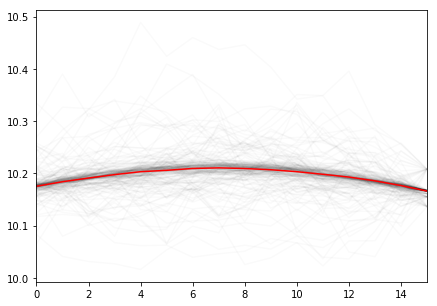

In [246]:
fig, ax = plt.subplots(1, figsize = (7, 5))
qi_totals = result.iloc[:, 1:17].sample(200).T
# np.log10(lin_levs.sum()/10).plot(color = 'r', ax = ax)
np.log10(qi_totals).plot(legend = False, alpha = 0.02, color = 'k', ax = ax)
arit_mean = np.log10(result.iloc[:, 1:17]).mean()
arit_mean.plot(color = 'r', ax = ax)

arit_mean.std()
abs(np.polyfit(range(T), arit_mean.values, 2)[0]*(T/2)**2)

In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

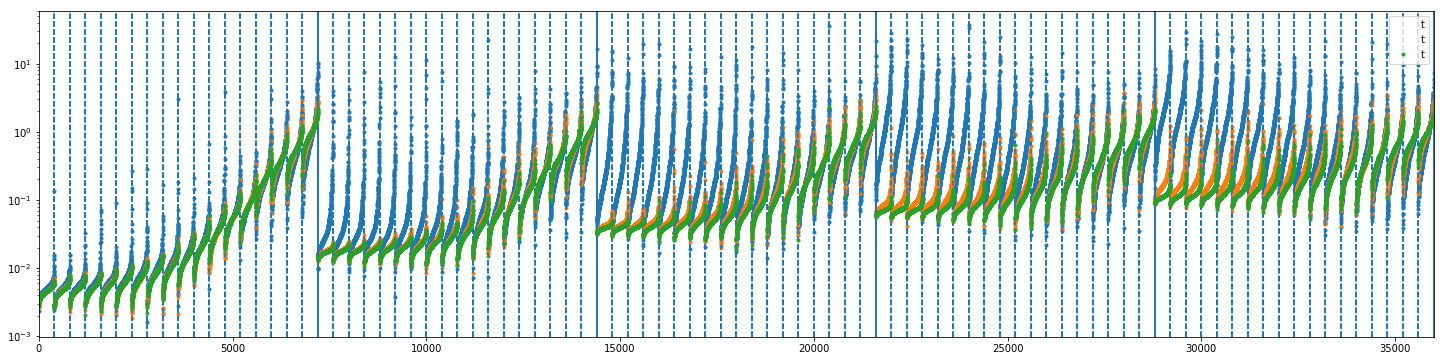

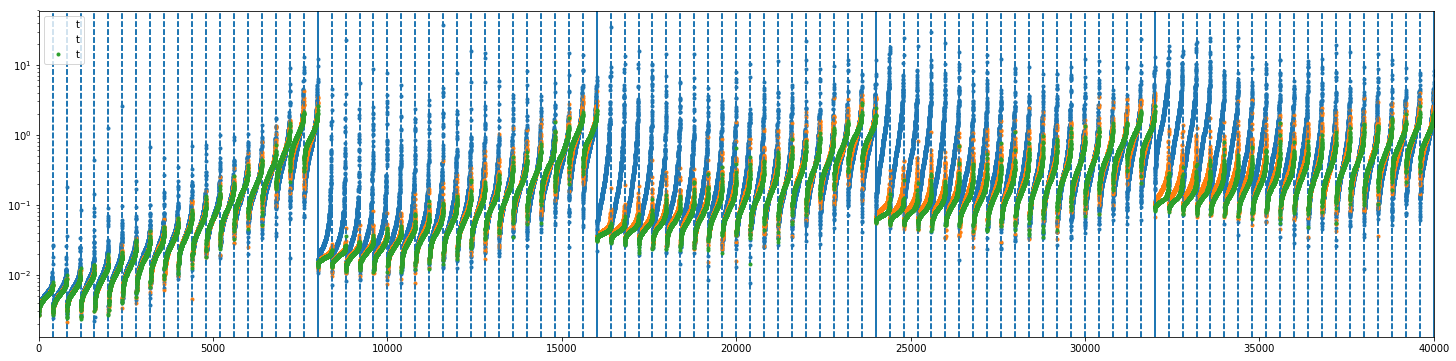

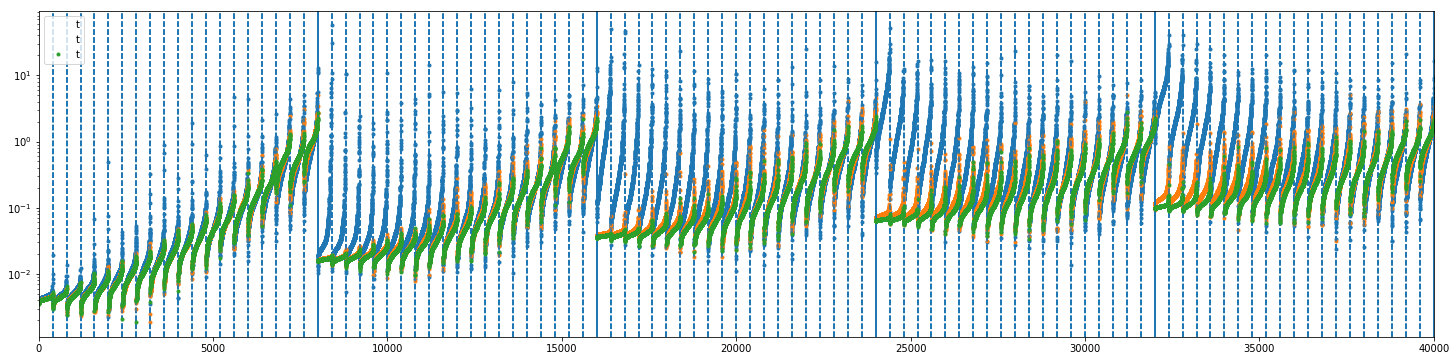

In [5]:
# for sizes in ['pareto', 'logn90', 'logn']:
#     fig, ax = plt.subplots(1, figsize = (25, 6))

#     for k, dist in enumerate(['sbtn', 'lapl', 'norm']):        
#         filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
#         result = pd.read_csv(filename)
#         result = result.loc[result.Q == 20]
#         result['t'] = result['var_diff_qi']/(result['s']**2)
#         y = 't'
#         sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         [ax.axvline(l, linestyle = '--') for l in sorted_.groupby(['dist','s', 'q']).count().iloc[:, 0].cumsum().values]
#         [ax.axvline(l, lw = 2) for l in sorted_.groupby(['s','Q']).count().iloc[:, 0].cumsum().values]
#         sorted_.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0)
#         ax.set_yscale('log')

In [43]:
# result.loc[(result.Q == 10) & (result.q == 0)].sort_values(by = 'var_qi')

In [26]:
import seaborn as sns

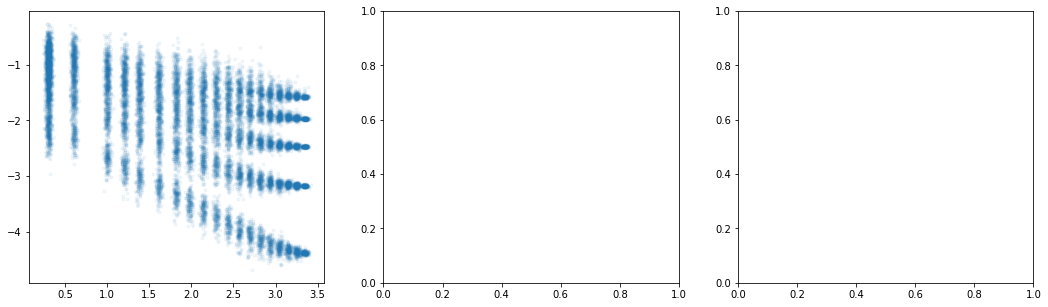

In [53]:
# Load
results = []
for j, x1 in enumerate([x_pareto, x_logn_clip3]):
    sizes = ['pareto', 'logn90', 'logn'][j]
    for k, dist in enumerate(['sbtn', 'lapl', 'norm']):        
        filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
        results += [pd.read_csv(filename)]

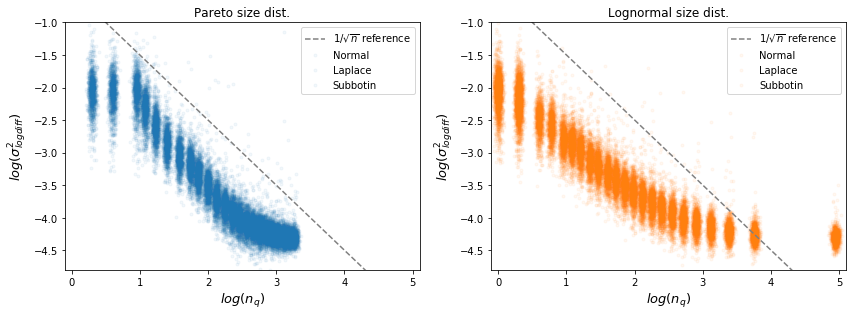

In [112]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4.5))

Q_ = 25
s = .1

for j, x1 in enumerate([x_pareto, x_logn_clip3]):
    N = len(x1)
    sizes = ['pareto', 'logn'][j]
    for k, dist in enumerate(['sbtn', 'lapl', 'norm']):
        ax = axs[j]
        df = results[3*j + k][['Q','q', 'var_diff_qi','s']]
        df = df.loc[(df.Q == Q_) & (df.s == s)]
        df['t'] = df['var_diff_qi']/(df['s']**2)
        bins, ns = get_n(x1, Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        df = df.merge(ns)
        df['log_n'] = np.log10(df.n)
        df['log_var_diff_qi'] = np.log10(df.var_diff_qi)

        frac = 1; alpha = .05
#         frac = .1; alpha = .5
        data=df.sample(frac = frac); data.log_n = data.log_n + np.random.normal(0, 0.03, len(data))
        ax.scatter(x=data.log_n.values, y=data.log_var_diff_qi.values, alpha = alpha, marker = '.', 
                   label = ['Normal', 'Laplace', 'Subbotin'][k], color = ['#1f77b4', '#ff7f0e'][j])
        ax.set_title(['Pareto', 'Lognormal'][j]+' size dist.')
        ax.set_xlabel(r'$log(n_q)$', fontsize = 13)
        ax.set_ylabel(r'$log(\sigma^2_{logdiff})$', fontsize = 13)
        ax.set_xlim(-0.1, 5.1)
        ax.set_ylim(-4.8, -1)
        x_ = np.arange(0, 6, 1)
    ax.plot(x_, -x_-.5, linestyle = '--', color = '.5', label = r'$1/\sqrt{n}$ reference')
    ax.legend()
        
plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/sigma_logn_sizedist.png', dpi = 400)
plt.show()
# colors:
# ['#1f77b4',
#  '#ff7f0e']

#         y = 't'
#         sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         [ax.axvline(l, linestyle = '--') for l in sorted_.groupby(['dist','s', 'q']).count().iloc[:, 0].cumsum().values]
#         [ax.axvline(l, lw = 2) for l in sorted_.groupby(['s','Q']).count().iloc[:, 0].cumsum().values]
#         sorted_.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0)
#         ax.set_yscale('log')

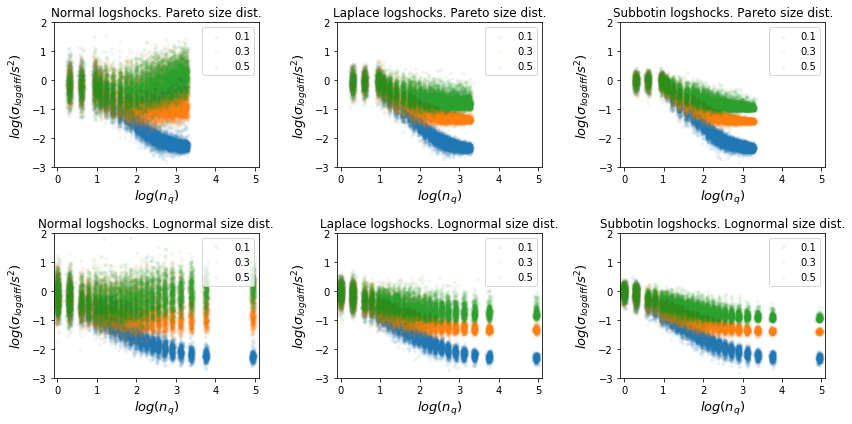

In [109]:
fig, axs = plt.subplots(2, 3, figsize = (12, 6))

Q_ = 25

for j, x1 in enumerate([x_pareto, x_logn_clip3]):
# for j, x1 in enumerate([x_logn_clip3]):
    N = len(x1)
    sizes = ['pareto', 'logn'][j]
    for k, dist in enumerate(['sbtn', 'lapl', 'norm']):
        ax = axs[j][k]
        df = results[3*j + k][['Q','q', 'var_diff_qi','s']]
        df = df.loc[(df.Q == Q_)]
        df['t'] = df['var_diff_qi']/(df['s']**2)
        bins, ns = get_n(x1, Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        df = df.merge(ns)
        df['log_n'] = np.log10(df.n)

        frac = 1; alpha = .05
        for s in [.1, .3, .5]:
            df['log_var_diff_qi'] = np.log10(df.var_diff_qi) - np.log10(s**2)
            data = df[df.s == s].sample(frac = frac); data.log_n = data.log_n + np.random.normal(0, 0.03, len(data))
            ax.scatter(x=data.log_n.values, y=data.log_var_diff_qi.values, alpha = alpha, marker = '.', label = str(s))
        ax.set_title(['Normal', 'Laplace', 'Subbotin'][k]+' logshocks. '+['Pareto', 'Lognormal'][j]+' size dist.')
        ax.legend()
        ax.set_xlabel(r'$log(n_q)$', fontsize = 13)
        ax.set_ylabel(r'$log(\sigma_{logdiff} / s^2)$', fontsize = 13)
        ax.set_xlim(-0.1, 5.1)
        ax.set_ylim(-3, 2)
        
plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/sigma_logn_s.png', dpi = 400)
plt.show()


In [ ]:
['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']